# Машинное обучение 2020, часть 2, семинар 2. Свёрточные и рекуррентные нейронные сети с помощью PyTorch

Два важных класса нейросетевых архитектур - свёрточные и рекуррентные нейронные сети

Первые активно используются для обработки изображений, а вторые - для обработки текстов

## Свёрточные нейронные сети

Напоминание: что такое свёрточная нейронная сеть?

![](https://previews.dropbox.com/p/thumb/AA48ZzdhjfdITdBivGpOcdM1Ug3c5jRNJkOt_Gp7oMLJLwEO-OCRc3hXJYbdDYPv_S6rk-S0o6gCy0j8a70C7SQ48gslWVsD51GdmWLIqc6YPkAnRCXKHgx-psWksPoy771eWV75ZKZnpGInxNFKvFabj4AvA1kReuLeUtd-9k6o1TWo1NAPYZgd0n2fB1SVFj15AaIlCSk7l0qAuimdEQb15eSVdbTlEuz1R_DyV-EjFXPbFMWlkzTRsACVEJexSnWXCdL9hhT0HBf45lxRy_r53TLVmGSH9PLvOzY3ePMVlWCIbfnO1e9bw6Mx5rsFNGSRJadD2E8lWI08s-odqXEBA0QdildBvE4oD2D_DwWcHQ/p.png?fv_content=true&size_mode=5)

Итак, чтобы состряпать свёрточную нейронную сеть (как и любую другую), нам понадобится:
* загрузить данные
* посмотреть на них и подготовить
* определить архитектуру сети
* обучить сеть
* посчитать качество

В PyTorch для работы с изображениями есть специальный пакет `torchvision`

### Данные

In [ ]:
import torch
import torchvision
from torchvision.transforms import transforms

Решать будем задачу классификации.

Работать будем с датасетом [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Он состоит из 60000 картинок 32x32, равномерно разбитых на 10 классов.

Загруженные картинки будут представлять из себя объекты типа PIL Image со значениями интенсивностей по каналам в диапазоне [0, 1]. Чтобы ими пользоваться для обучения, нам нужно будет преобразовать их в тензоры с интенсивностями от -1 до 1:

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data


Загрузить-то мы загрузили, но для того, чтобы стандартные методы обучения работали, нужно создать `DataLoader` и объяснить ему, как загружать данные:

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

Аналогично с тестовой выборкой:

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

Files already downloaded and verified


Кроме того, в датасете метки классов записаны числами, а нам интереснее было бы посмотреть на их названия, поэтому захардкодим их:

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Немного посмотрим на данные

Напомню, что раз мы их загружали и сразу конвертировали в тензор, а также нормализовали, нужно провести немножечко манипуляций:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

**Неочевидно**: менять местами оси нужно потому, что torchvision загружает данные в формате, в котором количество каналов идёт первым.

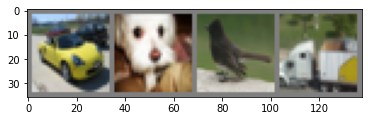

car dog bird truck


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[label] for label in labels))

### Архитектура сети

Для начала воспользуемся несложной архитектурой: два свёрточных слоя и буквально три полносвязных

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Неочевидно**: при создании слоя fc1 мы указываем размер входных данных 16 * 6 * 6. Откуда берётся 16 понятно: это количество каналов. 6 * 6 берётся же из итогового оставшегося размера картинки к этому моменту.

**Неочевидно**: несмотря на то, что мы хотим считать вероятности классов, использовать softmax не нужно. Дальше мы будем использовать `nn.CrossEntropyLoss`, который производит softmax внутри себя и требует ненормализованных данных.

Посмотрим на итоговую архитектуру сети:

In [ ]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Функция потерь и оптимизатор

Далее, как мы помним, нужно определить функцию потерь и отпимизатор:

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Обучение сети

Далее - обучение:

Если вы обучаете не в Google Colab (либо где-то в похожем месте), а на обычном ноубтуке, следующая ячейка будет выполняться довольно долго (минут 10). В рамках семинара мы воспользуемся её итоговым результатом для изучения, загрузив из ячейки после.

In [ ]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.196
[1,  4000] loss: 1.877
[1,  6000] loss: 1.679
[1,  8000] loss: 1.554
[1, 10000] loss: 1.489
[1, 12000] loss: 1.422
[2,  2000] loss: 1.353
[2,  4000] loss: 1.325
[2,  6000] loss: 1.308
[2,  8000] loss: 1.290
[2, 10000] loss: 1.247
[2, 12000] loss: 1.219


### Загрузка и сохранение модели

Этап сохранения в семинаре пропускаем: модель была обучена заранее.

In [ ]:
#torch.save(net.state_dict(), 'saved_model.pth')

А вот загрузить загрузим:

In [ ]:
net = Net()
net.load_state_dict(torch.load('saved_model.pth'))

FileNotFoundError: ignored

**Неочевидно**. "Нельзя просто так взять и" загрузить модель из файла. Полностью должны совпадать параметры, а также могут возникнуть некоторые сложности из-за различных версий PyTorch либо наличия GPU.

### Исследование обученной модели

Возьмём и посмотрим опять на некоторые примеры:

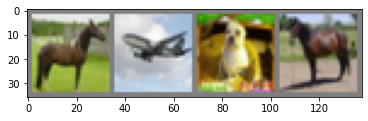

horse plane dog horse


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[label] for label in labels))

Что же для них выдаёт модель?

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(classes[label] for label in predicted))

Predicted:  horse plane bird horse


Вроде норм, что по качеству?

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: ' + str(100 * correct / total))

Accuracy: 56.83


Очень неплохая точность! Но можно лучше ;) Как вы думаете, кому это предстоит продемонстрировать?

**Задача 1 (1.5 балла).** Докажите, что можно лучше! Добейтесь 70+% качества.

In [ ]:
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = x.view(-1, 64 * 4 * 4)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x

In [ ]:
number_epochs = 10
learning_rate = 1e-3
momentum = 0.9

In [ ]:
better_cnn  = BetterNet()
better_cnn

BetterNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(better_cnn.parameters(), lr=learning_rate, momentum=momentum)

Trainig step for BetterNet

In [ ]:
import time

for epoch in range(number_epochs):
    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = better_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'Epoch {epoch+1}, picture {i+1:5d} - loss: {running_loss / 2000:.3f} - {time.time() - start_time:.3} seconds')
            running_loss = 0.0
            start_time = time.time()

Epoch 1, picture  2000 - loss: 2.240 - 25.5 seconds
Epoch 1, picture  4000 - loss: 1.874 - 25.9 seconds
Epoch 1, picture  6000 - loss: 1.679 - 24.9 seconds
Epoch 1, picture  8000 - loss: 1.549 - 25.4 seconds
Epoch 1, picture 10000 - loss: 1.439 - 25.3 seconds
Epoch 1, picture 12000 - loss: 1.348 - 24.9 seconds
Epoch 2, picture  2000 - loss: 1.256 - 24.7 seconds
Epoch 2, picture  4000 - loss: 1.195 - 24.6 seconds
Epoch 2, picture  6000 - loss: 1.139 - 25.0 seconds
Epoch 2, picture  8000 - loss: 1.109 - 25.0 seconds
Epoch 2, picture 10000 - loss: 1.074 - 24.9 seconds
Epoch 2, picture 12000 - loss: 1.033 - 24.8 seconds
Epoch 3, picture  2000 - loss: 0.907 - 24.7 seconds
Epoch 3, picture  4000 - loss: 0.898 - 24.3 seconds
Epoch 3, picture  6000 - loss: 0.898 - 24.2 seconds
Epoch 3, picture  8000 - loss: 0.872 - 23.9 seconds
Epoch 3, picture 10000 - loss: 0.868 - 24.3 seconds
Epoch 3, picture 12000 - loss: 0.856 - 24.0 seconds
Epoch 4, picture  2000 - loss: 0.721 - 24.3 seconds
Epoch 4, pic

Evaluating step for better net

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = better_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: ' + str(100 * correct / total))

Accuracy: 74.86


https://i.pinimg.com/originals/eb/ae/f4/ebaef44cca839e08eedebb2f5f80ea13.jpg

### Советы про свёрточные сети

1. Не делайте чрезмерно много фильтров в самом начале

2. Обычно чем более глубокий слой, тем больше вы свёрток хотите

Понять эти два совета нам поможет картинка про receptive field:

<img src="https://www.mdpi.com/remotesensing/remotesensing-09-00480/article_deploy/html/images/remotesensing-09-00480-g004.png" alt="drawing" width="500"/>

3. Одну свёртку 5x5 можно заменить на 2 свёртки 3x3

![](https://images.ctfassets.net/be04ylp8y0qc/2mdl25WmZWCHo7Y17Hl4jE/77ccc1a797ab15a486fc44403a3b9bdc/convolution.png?fm=jpg)

4. Следите за размером свёрток, которые вы применяете, и размером оставшейся картинки

## Рекуррентные нейронные сети

Напоминание: что такое рекуррентная нейронная сеть?

![](https://cdn-images-1.medium.com/max/1600/1*4KwIUHWL3sTyguTahIxmJw.png)

В PyTorch есть и модуль для работы с текстами - [torchtext](https://pytorch.org/text), но использовать мы его не будем.

Да и вообще, успешные идеи реализуются в современных фреймворках довольно быстро. Среди слоёв нейронных сетей в PyTorch можно найти в том числе и [трансформеры](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer)

### Данные

Одна из интересных особенностей рекуррентных сетей - это то, что они могут генерировать не одно число в качестве ответа, а целую последовательность чего-либо

Поэтому мы и займёмся генерацией! К сожалению, в torchtext подходящих датасетов нет :(

Качаем [данные](https://yadi.sk/i/U91Z9KAbUsE2OQ) и кладём их в папку с ноутбуком

Собственно, данные представляют из себя русские фамилии, записанные латиницей. На основе одних фамилий, хотим генерировать новые :)

Давайте загрузим и посмотрим на парочку из них:

In [ ]:
names = []
all_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
n_letters = len(all_letters) + 1

with open('Russian_names.txt') as f:
    for line in f:
        line = line.strip()
        if all(l in all_letters for l in line):
            names.append(line.strip())

In [ ]:
print(names[:5])

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']


Какие-то они странноватые... Посмотрим, есть ли "исконно русские":

In [ ]:
print('Ivanov' in names)
print('Petrov' in names)
print('Sidorov' in names)

True
True
False


Во, так лучше! Хоть и без Сидорова.

Есть одна (далеко не одна) проблема: у нас тут слова, а PyTorch принимает тензоры. Да и вообще, непонятно: что будет обучающим примером, а что ответом?

Картинка поможет разобраться!

![](https://i.imgur.com/JH58tXY.png)

Получается, что на вход даётся символ, и на выход получаем тоже символ. Но из одного слова получается прям пачка, давайте её и научимся переводить в тензор:

In [ ]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i in range(len(line)):
        letter = line[i]
        tensor[i][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

**Неочевидно**. Нашей сети когда-нибудь нужно остановиться. "Пора остановиться" - это тот самый +1 токен, прибавляемый к количеству всех букв.

**Неочевидно**. Мы будем использовать по сути мини-батч, построенный по одному слову. Если же мы хотим построить его по нескольким словам и бежать по сети то всё сложнее. Слова попадаются разной длинны, а прям сходу с этим непонятно как работать.

На помощь приходит дописывание к каждому слову символов вплоть до длинны самого длинного. Используются методы [torch.nn.utils.rnn.pack_padded_sequence](https://pytorch.org/docs/master/generated/torch.nn.utils.rnn.pack_padded_sequence.html) и [torch.nn.utils.rnn_pad_packed_sequence](https://pytorch.org/docs/master/generated/torch.nn.utils.rnn.pad_packed_sequence.html)

**Неочевидно**. В качестве входа нам "по-любому" нужен тензор, который мы можем умножать смело. В данном случае - one-hot-encoding. На выходе же для подсчёта потерь нам достаточно и просто номера буквы, в one-hot переводить не обязательно.

### Архитектура сети

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

![](https://i.ibb.co/4NMJ8Hx/Screenshot-from-2020-09-21-20-04-54.png)

In [ ]:
rnn = RNN(n_letters, 128, n_letters)
rnn

RNN(
  (i2h): Linear(in_features=181, out_features=128, bias=True)
  (i2o): Linear(in_features=181, out_features=53, bias=True)
  (o2o): Linear(in_features=181, out_features=53, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

### Обучение сети

Тут воспользуемся аналогом кросс-энтропии: negative log likelihood. Суть то же самое, но в данной ситуации на последнем слое нам понадобится softmax.

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

Также напишем одну итерацию обучения:

In [ ]:
def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

И погнали!

In [ ]:
n_iters = 50
running_loss = 0.0

for epoch in range(1, n_iters + 1):
    for i in range(len(names)):
        name = names[i]
        input_tensor = inputTensor(name)
        target_tensor = targetTensor(name)
        output, loss = train(input_tensor, target_tensor)
        
        running_loss += loss
        if i % 4500 == 4499:
            print(f'Epoch: {epoch + 1} -  loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

Epoch: 2 -  loss: 9.226
Epoch: 2 -  loss: 9.329
Epoch: 3 -  loss: 9.851
Epoch: 3 -  loss: 9.243
Epoch: 4 -  loss: 9.800
Epoch: 4 -  loss: 9.207
Epoch: 5 -  loss: 9.750
Epoch: 5 -  loss: 9.151
Epoch: 6 -  loss: 9.720
Epoch: 6 -  loss: 9.138
Epoch: 7 -  loss: 9.725
Epoch: 7 -  loss: 9.098
Epoch: 8 -  loss: 9.675
Epoch: 8 -  loss: 9.071
Epoch: 9 -  loss: 9.641
Epoch: 9 -  loss: 9.067
Epoch: 10 -  loss: 9.631
Epoch: 10 -  loss: 9.021
Epoch: 11 -  loss: 9.605
Epoch: 11 -  loss: 9.004
Epoch: 12 -  loss: 9.591
Epoch: 12 -  loss: 9.004
Epoch: 13 -  loss: 9.596
Epoch: 13 -  loss: 9.007
Epoch: 14 -  loss: 9.555
Epoch: 14 -  loss: 8.990
Epoch: 15 -  loss: 9.549
Epoch: 15 -  loss: 8.951
Epoch: 16 -  loss: 9.522
Epoch: 16 -  loss: 8.925
Epoch: 17 -  loss: 9.572
Epoch: 17 -  loss: 8.926
Epoch: 18 -  loss: 9.505
Epoch: 18 -  loss: 8.936
Epoch: 19 -  loss: 9.524
Epoch: 19 -  loss: 8.911
Epoch: 20 -  loss: 9.519
Epoch: 20 -  loss: 8.934
Epoch: 21 -  loss: 9.501
Epoch: 21 -  loss: 8.908
Epoch: 22 -  los

**Задание 2 (1 балл)**. Напишите функцию генерации слов на основе обученной модели. Она должна принимать на вход модель и букву, с которой начинать генерацию. Обучите модель подольше и проверьте её на нескольких начальных буквах!

In [95]:
def surname_generation(model, letter='A', batch_size=1):
  assert len(letter) == 1, 'Should be one letter'

  input = inputTensor(letter)[0]
  hidden = model.initHidden(batch_size)

  output, hidden = model(input, hidden)

  pred_surname = letter
  idx = torch.argmax(output)

  while idx != n_letters - 1:
    idx = torch.argmax(output)
    next_letter = all_letters[idx]
    pred_surname += next_letter

    input = inputTensor(next_letter)[0]
    output, hidden = model(input, hidden)
    idx = torch.argmax(output)

  return pred_surname

In [ ]:
for i in range(3):
  print(surname_generation(rnn, 'A')) 

Averin
Awerichenki
Awelinovik


In [ ]:
for i in range(3):
  print(surname_generation(rnn, 'M'))

Muzhin
Muzhalovich
Muzhin


In [ ]:
for i in range(3):
  print(surname_generation(rnn, 'O'))

Onin
Onishevich
Oterinov


In [ ]:
for i in range(3):
  print(surname_generation(rnn, 'B'))

Belinov
Beletsovic
Beltov


In [ ]:
for i in range(3):
  print(surname_generation(rnn, 'I'))

Iskin
Ilatsky
Iserin


In [ ]:
for i in range(3):
  print(surname_generation(rnn, 'R'))

Ruzhanin
Ruzev
Ruzhankov


**Задание 3 (0.5 балла)**. На самом деле в PyTorch есть встроенный модуль [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). Заиспользуйте его для этой задачи вместо самописного умножения на матрицы. Также воспользуйтесь каким-нибудь встроенным оптимизатором вместо самописного градиентного спуска.

In [77]:
class BetterRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BetterRNN, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_size)
        return hidden

In [78]:
better_rnn = BetterRNN(n_letters, n_letters)
better_rnn

BetterRNN(
  (rnn): RNN(53, 53, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

In [89]:
n_epochs = 10
batch_size = 256
learning_rate = 0.0005
momentum = 0.9

In [90]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(better_rnn.parameters(), lr=learning_rate, momentum=momentum)

In [91]:
import time

for epoch in range(n_epochs + 1):
  for i in range(len(names) //  batch_size + 1):
    running_loss = 0.0
    start_time = time.time()
    
    # name = names[i]
    # input_tensor = inputTensor(name)
    # target_tensor = targetTensor(name)

    hidden = better_rnn.initHidden(input_tensor.size(0))
    optimizer.zero_grad()
    
    output, hidden = better_rnn(input_tensor, hidden)
    output = output.squeeze()
    
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()
    
    running_loss += loss
    if i % 2 == 0:
      print(f'Epoch: {epoch} -  loss: {running_loss / 1000:.6f} - {time.time() - start_time:.3} seconds')
      running_loss = 0.0
      start_time = time.time()

Epoch: 0 -  loss: 0.000000 - 0.000626 seconds
Epoch: 0 -  loss: 0.000000 - 0.000625 seconds
Epoch: 1 -  loss: 0.000000 - 0.000569 seconds
Epoch: 1 -  loss: 0.000000 - 0.000611 seconds
Epoch: 2 -  loss: 0.000000 - 0.000593 seconds
Epoch: 2 -  loss: 0.000000 - 0.000589 seconds
Epoch: 3 -  loss: 0.000000 - 0.0006 seconds
Epoch: 3 -  loss: 0.000000 - 0.000611 seconds
Epoch: 4 -  loss: 0.000000 - 0.000575 seconds
Epoch: 4 -  loss: 0.000000 - 0.000617 seconds
Epoch: 5 -  loss: 0.000000 - 0.000575 seconds
Epoch: 5 -  loss: 0.000000 - 0.000628 seconds
Epoch: 6 -  loss: 0.000000 - 0.000616 seconds
Epoch: 6 -  loss: 0.000000 - 0.000593 seconds
Epoch: 7 -  loss: 0.000000 - 0.000756 seconds
Epoch: 7 -  loss: 0.000000 - 0.000601 seconds
Epoch: 8 -  loss: 0.000000 - 0.000599 seconds
Epoch: 8 -  loss: 0.000000 - 0.000619 seconds
Epoch: 9 -  loss: 0.000000 - 0.000813 seconds
Epoch: 9 -  loss: 0.000000 - 0.000596 seconds
Epoch: 10 -  loss: 0.000000 - 0.000606 seconds
Epoch: 10 -  loss: 0.000000 - 0.000